# Sanity checks

Just making sure that all the helper functions are doing reasonable things.

TODO:
<ul>
    <li> Add horizontal flipping </li>
</ul>

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [263]:
import numpy as np
import torch
from torch.optim import SGD
import albumentations as A
from albumentations.pytorch import ToTensorV2
from matplotlib import pyplot as plt
from torch.optim import Adam

In [15]:
from pixpro.data import *
from pixpro.model import *

In [88]:
from pixpro.data import *
space_tfs = A.Compose([
    A.RandomResizedCrop(224, 224),
    A.HorizontalFlip()
], additional_targets={'grid_y': 'image', 'grid_x': 'image'})

view1_color_tfs = A.Compose([
    A.ColorJitter(0.4, 0.4, 0.2, 0.1, p=0.8),
    A.ToGray(p=0.2),
    A.GaussianBlur(blur_limit=23, sigma_limit=(0.1, 2.0), p=1.0),
    A.Normalize(),
    ToTensorV2()
])

#technically optional, but used in the BYOL paper
view2_color_tfs = A.Compose([
    A.ColorJitter(0.4, 0.4, 0.2, 0.1, p=0.8),
    A.ToGray(p=0.2),
    A.GaussianBlur(blur_limit=23, sigma_limit=(0.1, 2.0), p=0.1),
    A.Solarize(p=0.2),
    A.Normalize(),
    ToTensorV2()
])

data = ContrastData('./imagenette_data/', space_tfs, view1_color_tfs, view2_color_tfs)

Found 3925 images in directory


In [89]:
def move_channel_dim(image):
    image = image.copy()
    image -= image.min()
    image /= image.max()
    image *= 255
    return np.rollaxis(image.astype(np.uint8), 0, 3)

(224, 224, 2)


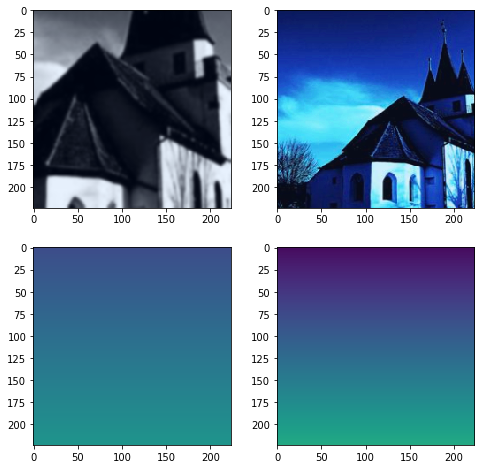

In [147]:
index = np.random.randint(0, len(data))
output = data[index]

view1 = output['view1']
view2 = output['view2']
view1_grid = output['view1_grid']
view2_grid = output['view2_grid']

f, ax = plt.subplots(2, 2, figsize=(8, 8))
ax[0, 0].imshow(move_channel_dim(view1.numpy()))
ax[0, 1].imshow(move_channel_dim(view2.numpy()))
ax[1, 0].imshow(view1_grid[0].numpy(), vmin=0, vmax=450)
ax[1, 1].imshow(view2_grid[0].numpy(), vmin=0, vmax=450)

Images look more distorted than I would expect, but these are the parameters from the BYOL paper. Note that we don't want to apply any augmentations that affect physical space (color space is free game).

In [231]:
from torchvision.models import mobilenet_v2 #tiny model to test on cpu

In [232]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [237]:
view1_grid.size()

torch.Size([2, 224, 224])

In [238]:
view1_in = view1.unsqueeze(0).to(device)
view2_in = view2.unsqueeze(0).to(device)
view1_grid_in = view1_grid.unsqueeze(0).to(device)
view2_grid_in = view2_grid.unsqueeze(0).to(device)

In [262]:
from pixpro.model import *
model = PixPro(mobilenet_v2(), 1, downsampling=32)
model = model.to(device)
model = model.train()

In [265]:
optimizer = Adam(model.parameters(), lr=3e-4)
criterion = ConsistencyLoss(distance_thr=0.7).to(device)

In [ ]:
for e in range(2):
    optimizer.zero_grad()
    
    y1, y2, z1, z2, v1_grid, v2_grid = model(view1_in, view2_in, view1_grid_in, view2_grid_in)
    loss = criterion(y1, y2, z1, z2, v1_grid, v2_grid)
    
    loss.backward()
    optimizer.step()
    
    print(loss.item())

In [244]:
with torch.no_grad():
    y1, y2, z1, z2, v1_grid, v2_grid = model(view1_in, view2_in, view1_grid_in, view2_grid_in)

Red dot in the first image is the pixel in view1 and the mask on the right show "positive pair" pixels in view2. Change distance_thr of the model to adjust the size of the circle.

In [260]:
k = criterion(y1, y2, z1, z2, v1_grid, v2_grid)

torch.Size([1, 49, 49])
